# Analysis

This notebook contains the analysis of the data tracked on
[Weights & Biases](https://wandb.ai/).


## Setup

---

We will first setup everything so that we can easily analyse the experiment
results. This includes importing the necessary libraries, setting paths, loading
the experiment results from W&B.


In [1]:
# ruff: noqa
%load_ext autoreload
%autoreload 2

# Bult-in modules
import os
import sys

sys.path.insert(0, "..")

# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

# External modules
# - Data Representation
import pandas as pd
import numpy as np

# - Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns
import plotnine as pn

# - Machine Learning
import torch

# - Experiment Configuration and Logging
import wandb

# Custom modules
from utils import eval_utils as utils

In [2]:
# Setup of global variables
ROOT_DIR = os.path.dirname(os.path.abspath("."))
ARTIFACT_DIR = os.path.join(ROOT_DIR, "artifacts")
FIGURE_DIR = os.path.join(ROOT_DIR, "figures")
TABLE_DIR = os.path.join(ROOT_DIR, "report", "tables")

METHODS = ["baseline", "baseline_pp", "matchingnet", "protonet", "maml"]
METHODS_WITH_SOT = []
for method in METHODS:
    METHODS_WITH_SOT.append(method)
    METHODS_WITH_SOT.append(method + "_sot")

STYLED_METHODS = ["Baseline", "Baseline++", "MatchingNet", "ProtoNet", "MAML"]
STYLED_METHODS_WITH_SOT = []
for method in STYLED_METHODS:
    STYLED_METHODS_WITH_SOT.append(method)
    STYLED_METHODS_WITH_SOT.append(method + " (SOT)")

styled_methods_dict = dict(zip(METHODS, STYLED_METHODS))


def get_name(name, sot=False):
    return styled_methods_dict[name] + (" (SOT)" if sot else "")

In [3]:
# Settings
sns.set_style("dark")
colorstyle = "RdBu"
sns.set_palette(colorstyle)

In [4]:
# Initialize wandb
WANDB_PROJECT = "few-shot-benchmark"
WANDB_ENTITY = "metameta-learners"

# Initialize W&B API
api = wandb.Api()

# Get all runs
runs = api.runs(f"{WANDB_ENTITY}/{WANDB_PROJECT}")

## Experiment 1: Benchmark

---

All models on all datasets with and without SOT for fixed few-shot learning
setting (5-way 5-shot).


### Loading Experiment Data


In [5]:
# Get all runs for experiment `benchmark`
GROUP = "tuned-benchmark"

group_runs = [run for run in runs if run.group ==
              GROUP and run.state == "finished"]
print(f"✅ Found {len(group_runs)} runs")

✅ Found 187 runs


Next, we'll load all runs from the given experiment group into a single
dataframe.


In [6]:
df_runs = utils.load_to_df(group_runs)
print(f"✅ Loaded {len(df_runs)} runs.")

df_runs.head()

✅ Loaded 187 runs.


info                config            \
                                         name    runtime    dataset    method   
id                                                                              
xhag25gy  protonet-swissprot-sot-5-way-5-shot  41.468315  swissprot  protonet   
l44f5r3n  protonet-swissprot-sot-5-way-5-shot  59.784709  swissprot  protonet   
sfge218r  protonet-swissprot-sot-5-way-5-shot  68.427992  swissprot  protonet   
dmdcuf2o  protonet-swissprot-sot-5-way-5-shot  52.142571  swissprot  protonet   
mrol34qm  protonet-swissprot-sot-5-way-5-shot  37.431727  swissprot  protonet   

                                    eval                         ...  \
         use_sot n_way n_shot    val/acc test/acc_ci train/loss  ...   
id                                                               ...   
xhag25gy    True     5      5  86.933333    0.646484   0.244571  ...   
l44f5r3n    True     5      5  99.453333    0.140367   0.027856  ...   
sfge218r    True     5      5  88.413333    0.483614   0.078707  ...   
dmdcuf2o    True     5      5  98.866667    0.114001    0.03927  ...   
mrol34qm    True     5      5  83.480000    0.688567   0.271612  ...   

                                                                             \
           test/acc  train/acc val/acc_std train/acc_std epoch train/acc_ci   
id                                                                            
xhag25gy  80.520000  92.466667    7.796295      6.604712    11     0.528487   
l44f5r3n  99.206667  99.866667    1.623111      0.718022    20     0.057454   
sfge218r  87.533333  97.566667    7.206651      3.676804    22     0.294206   
dmdcuf2o  99.513333  99.660000    2.308439      1.162354    15     0.093008   
mrol34qm  76.046667  90.013333    9.240289      8.603865    11     0.688453   

         hyperparam                                            
                 lr sot_reg sot_sinkhorn_iter sot_dist_metric  
id                                                             
xhag25gy     0.0010     1.0                10       euclidean  
l44f5r3n     0.0010     0.1                10       euclidean  
sfge218r     0.0010     1.0                10          cosine  
dmdcuf2o     0.0010     0.1                10          cosine  
mrol34qm     0.0005     1.0                10       euclidean  

[5 rows x 22 columns]

### Grouping

Each experiment is uniquely identified by the following parameters:

- `dataset`: The dataset used (`swissprot`, `tabula_muris`)
- `method`: The model used (`baseline`, `baseline_pp`, `protonet`,
  `matchingnet`, `maml`)
- `use_sot`: Whether to include the SOT module (`True`, `False`)
- `n_way`: The number of classes in each episode
- `n_shot`: The number of support samples per class in each episode

For each experiment setting, there are multiple trained models because of
hyper-parameter tuning. We will group the runs by the above parameters and only
use the best-performing model on the validation set for the following analysis.


In [7]:
# Group tuning runs by experiment configuration
df_best_runs = utils.get_best_run(df_runs, metric=("eval", "val/acc"))
print(f"✅ Filtered to {len(df_best_runs)} best runs.")

# Let's also save two separate dataframes for the two different datasets
df_best_runs_tm = df_best_runs[df_best_runs[("config", "dataset")] == "tabula_muris"]
df_best_runs_sp = df_best_runs[df_best_runs[("config", "dataset")] == "swissprot"]

df_best_runs.head()

✅ Filtered to 20 best runs.


info                    config  \
                                               name     runtime       dataset   
l44f5r3n        protonet-swissprot-sot-5-way-5-shot   59.784709     swissprot   
mb6s32it  baseline_pp-tabula_muris-sot-5-way-5-shot  283.423143  tabula_muris   
9mzhwegk      baseline_pp-tabula_muris-5-way-5-shot  287.713995  tabula_muris   
pklw5upz     baseline_pp-swissprot-sot-5-way-5-shot  339.399153     swissprot   
g07tittq         baseline_pp-swissprot-5-way-5-shot  358.645061     swissprot   

                                                 eval                         \
               method use_sot n_way n_shot    val/acc test/acc_ci train/loss   
l44f5r3n     protonet    True     5      5  99.453333    0.140367   0.027856   
mb6s32it  baseline_pp    True     5      5  76.920000    0.934640   3.137616   
9mzhwegk  baseline_pp   False     5      5  82.566667    0.875316   0.262760   
pklw5upz  baseline_pp    True     5      5  75.646667    0.722091   3.982392   
g07tittq  baseline_pp   False     5      5  74.460000    0.694068   0.774483   

          ...                                                        \
          ...   test/acc  train/acc val/acc_std train/acc_std epoch   
l44f5r3n  ...  99.206667  99.866667    1.623111      0.718022    20   
mb6s32it  ...  82.760000  83.393333   13.783333     11.450995     6   
9mzhwegk  ...  81.880000  96.106667   11.271153      6.139649     8   
pklw5upz  ...  64.613333  73.366667   11.209898     12.618461     7   
g07tittq  ...  64.120000  96.066667   12.108471      4.589360    12   

                      hyperparam                                            
         train/acc_ci         lr sot_reg sot_sinkhorn_iter sot_dist_metric  
l44f5r3n     0.057454      0.001     0.1                10       euclidean  
mb6s32it     0.916270      0.001     0.1                10          cosine  
9mzhwegk     0.491274      0.001     0.1                10          cosine  
pklw5upz     1.009687      0.001     0.1                10          cosine  
g07tittq     0.367225      0.001     0.1                10          cosine  

[5 rows x 22 columns]

In [8]:
# Parse the results for both the report
tm_res = utils.exp2results(df_best_runs_tm)
sp_res = utils.exp2results(df_best_runs_sp)

# Create a MultiIndex for the results where the first level is the dataset
tm_res = tm_res.set_index("Method")
tm_res.index = pd.MultiIndex.from_product([["TM"], tm_res.index])
sp_res = sp_res.set_index("Method")
sp_res.index = pd.MultiIndex.from_product([["SP"], sp_res.index])

# Concatenate the results
df_results = pd.concat([tm_res, sp_res])

# Get the latex
latex = utils.exp2latex(df_results)

# Save the latex
with open(os.path.join(TABLE_DIR, "tuned-benchmark.tex"), "w") as f:
    f.write(latex)

df_results

Acc          w/ SOT   Diff
   Method                                       
TM B       $90.7 \pm 0.7$  $86.3 \pm 0.9$  -4.84
   B++     $81.9 \pm 0.9$  $82.8 \pm 0.9$   1.07
   MAML    $92.8 \pm 0.5$  $99.2 \pm 0.1$   6.86
   MT      $84.6 \pm 0.8$  $99.7 \pm 0.1$  17.90
   PT      $87.1 \pm 0.8$  $98.6 \pm 0.2$  13.23
SP B       $69.2 \pm 0.7$  $55.7 \pm 0.8$ -19.55
   B++     $64.1 \pm 0.7$  $64.6 \pm 0.7$   0.77
   MAML    $68.7 \pm 0.7$  $98.0 \pm 0.2$  42.79
   MT      $68.2 \pm 0.8$  $99.8 \pm 0.1$  46.46
   PT      $63.5 \pm 0.7$  $99.2 \pm 0.1$  56.13

### Train / Val / Test Performance for all models

Here, we plot a simple bar plot for all methods (5 methods, each with and
without SOT) on all three splits (train, val, test). Performances are shown in
two separate plots for Swissprot and Tabula Muris


✅ Saved figure to /Users/ludekcizinsky/Dev/personal/few-shot-benchmark/figures.


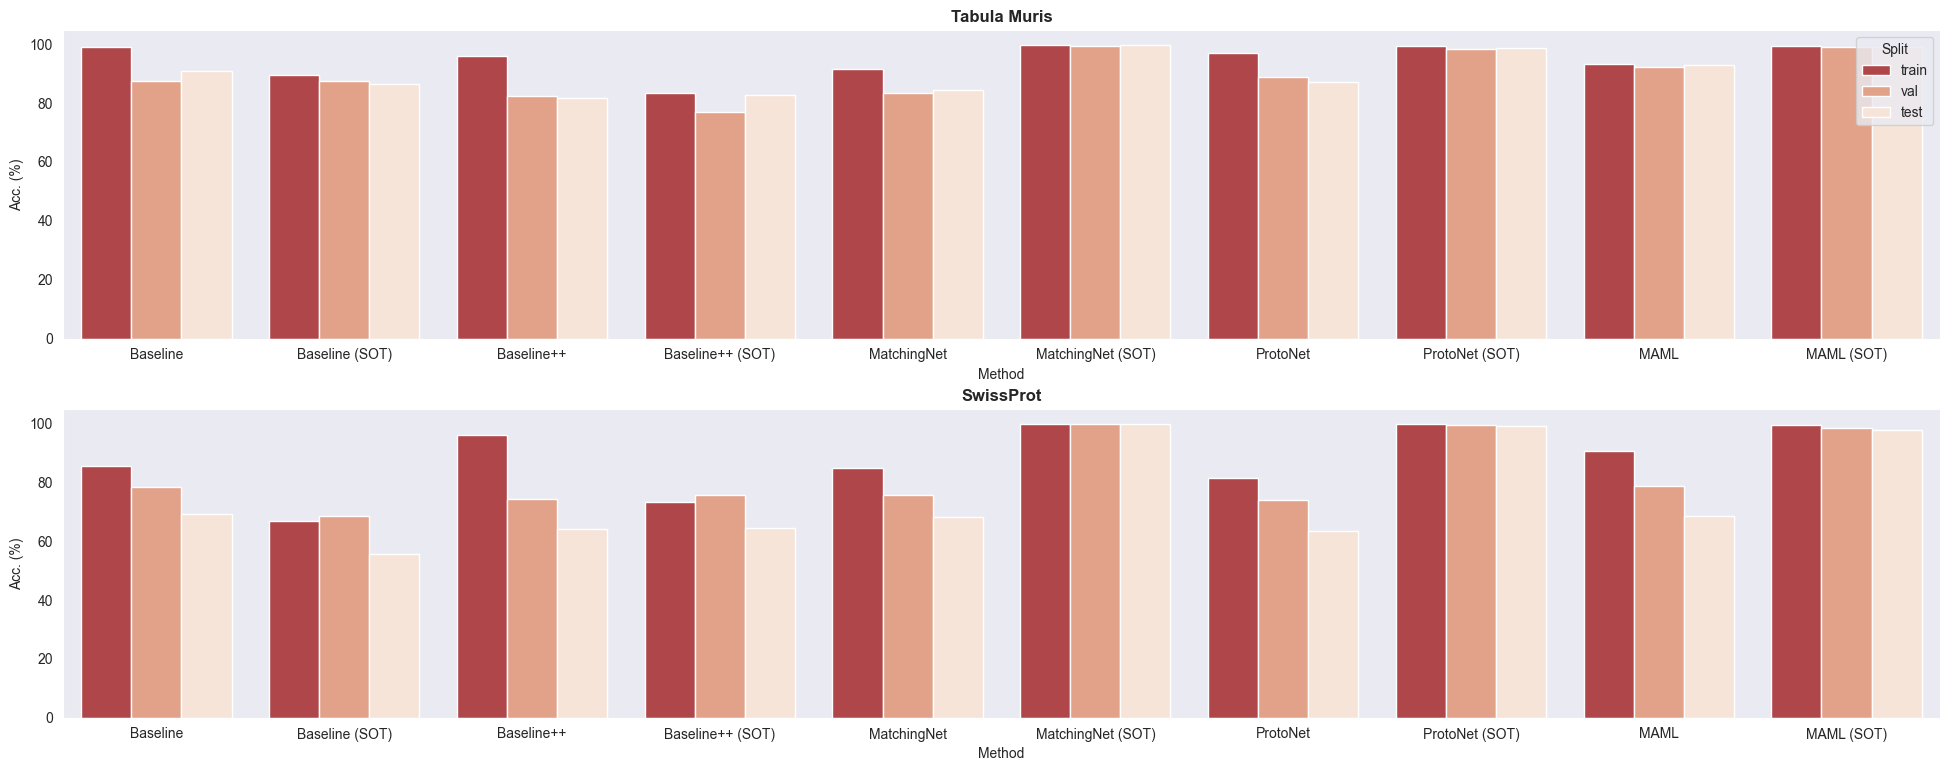

In [9]:
# Performance by split for all methods
fig, axs = plt.subplots(nrows=2, figsize=(20, 8))
fig.tight_layout(pad=3.0)


def pivot_acc(df):
    tmp = []
    for i, best_model in df.iterrows():
        for split in ["train", "val", "test"]:
            method_name = get_name(
                best_model[("config", "method")], best_model[("config", "use_sot")]
            )
            tmp.append(
                {
                    "method": method_name,
                    "split": split,
                    "acc": best_model[("eval", f"{split}/acc")],
                }
            )
    return pd.DataFrame(tmp)


sns.barplot(
    pivot_acc(df_best_runs_tm),
    x="method",
    y="acc",
    hue="split",
    order=STYLED_METHODS_WITH_SOT,
    ax=axs[0],
)
sns.barplot(
    pivot_acc(df_best_runs_sp),
    x="method",
    y="acc",
    hue="split",
    order=STYLED_METHODS_WITH_SOT,
    ax=axs[1],
)
# Set title
axs[0].set_title("Tabula Muris", fontweight="bold")
axs[1].set_title("SwissProt", fontweight="bold")

# Disable legend on first subplot
axs[0].get_legend().set_title("Split")
axs[1].get_legend().remove()

for ax in axs:
    ax.set_xlabel("Method")
    ax.set_ylabel("Acc. (%)")

fig.savefig(os.path.join(FIGURE_DIR, "benchmark-split-perf.pdf"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

### Performance by method with and without SOT

Here, we compare the performance of the different methods with and without SOT.
The left subplot shows the test performance on the Tabula Muris dataset, while
the right subplot shows the test performance on the Swissprot dataset.


✅ Saved figure to /Users/ludekcizinsky/Dev/personal/few-shot-benchmark/figures.


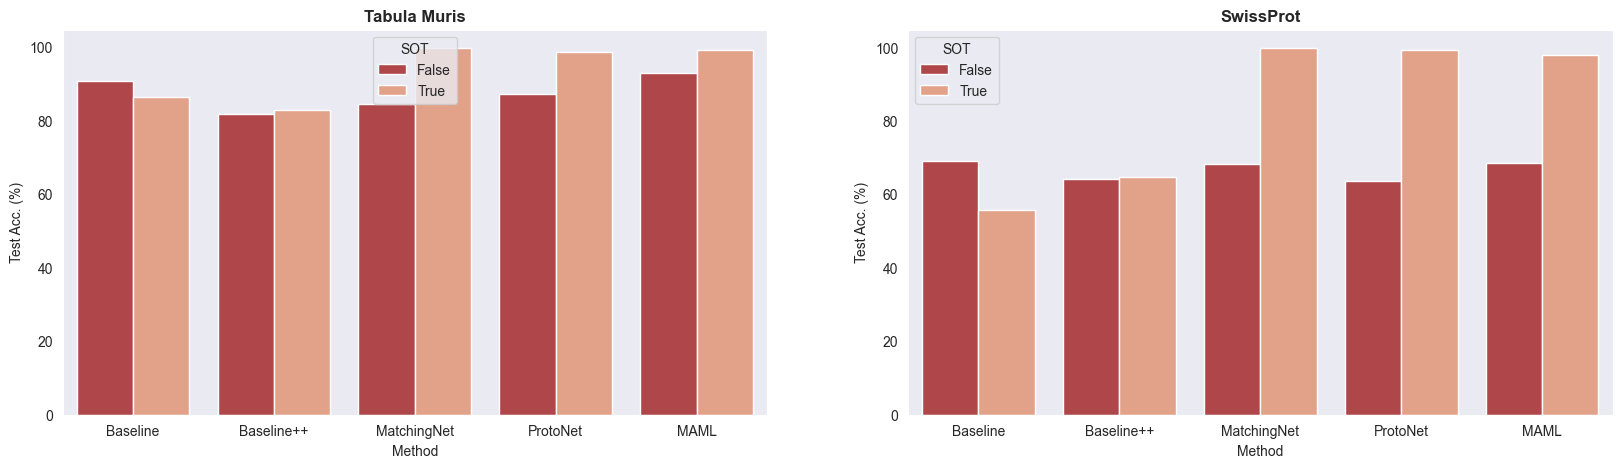

In [10]:
# Performance by method with and without SOT
fig, axs = plt.subplots(ncols=2, figsize=(20, 5))

sns.barplot(
    df_best_runs_tm,
    x=("config", "method"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    order=METHODS,
    ax=axs[0],
)

sns.barplot(
    df_best_runs_sp,
    x=("config", "method"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    ci="sd",
    order=METHODS,
    ax=axs[1],
)

# Set title
axs[0].set_title("Tabula Muris", fontweight="bold")
axs[1].set_title("SwissProt", fontweight="bold")

# Disable legend on first subplot
axs[0].get_legend().set_title("SOT")
axs[1].get_legend().set_title("SOT")

# Set axis labels
axs[0].set_xticklabels([get_name(name.get_text()) for name in axs[0].get_xticklabels()])
axs[1].set_xticklabels([get_name(name.get_text()) for name in axs[1].get_xticklabels()])

for ax in axs:
    ax.set_ylabel("Test Acc. (%)")
    ax.set_xlabel("Method")

# Save figure
fig.savefig(os.path.join(FIGURE_DIR, "benchmark-perf.pdf"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

## Experiment 2: Way-Shot Analysis

---

Varying the number of shots per class.


In [11]:
# Load experiment data for `way-shot` experiment
GROUP = "tuned-way-shot"

# Filter runs by group
group_runs = [run for run in runs if run.group ==
              GROUP and run.state == "finished"]
print(f"✅ Found {len(group_runs)} runs")

✅ Found 50 runs


In [12]:
# Load runs into dataframe
df_runs = utils.load_to_df(group_runs)
print(f"✅ Loaded {len(df_runs)} runs.")

df_runs.head()

✅ Loaded 50 runs.


info                   config  \
                                             name    runtime       dataset   
id                                                                           
1fjek4v6   protonet-tabula_muris-sot-2-way-1-shot  10.146370  tabula_muris   
onltvph0       protonet-tabula_muris-2-way-1-shot   5.802267  tabula_muris   
w93rkihk   protonet-tabula_muris-sot-2-way-5-shot  20.586317  tabula_muris   
12cd0470       protonet-tabula_muris-2-way-5-shot   9.851200  tabula_muris   
sua9fxt8  protonet-tabula_muris-sot-2-way-10-shot  26.501602  tabula_muris   

                                               eval                         \
            method use_sot n_way n_shot test/acc_ci val/acc_std    val/acc   
id                                                                           
1fjek4v6  protonet    True     2      1    0.586472    6.830792  97.083333   
onltvph0  protonet   False     2      1    1.231823   15.620499  91.000000   
w93rkihk  protonet    True     2      5    0.268570    2.687419  99.333333   
12cd0470  protonet   False     2      5    0.819714   10.510894  95.433333   
sua9fxt8  protonet    True     2     10    0.438099    4.598430  98.766667   

          ...                                                                \
          ...  train/acc train/acc_ci train/acc_std val/acc_ci test/acc_std   
id        ...                                                                 
1fjek4v6  ...  97.800000     0.517496      6.467354   0.546577     7.329374   
onltvph0  ...  92.433333     1.080706     13.506007   1.249900    15.394579   
w93rkihk  ...  99.566667     0.169342      2.116339   0.215038     3.356420   
12cd0470  ...  96.883333     0.677956      8.472685   0.841047    10.244294   
sua9fxt8  ...  99.700000     0.171181      2.139315   0.367951     5.475095   

                    hyperparam                                            
           test/acc         lr sot_reg sot_sinkhorn_iter sot_dist_metric  
id                                                                        
1fjek4v6  96.716667      0.001     0.1                10          cosine  
onltvph0  90.416667      0.001     0.1                10          cosine  
w93rkihk  98.966667      0.001     0.1                10          cosine  
12cd0470  94.766667      0.001     0.1                10          cosine  
sua9fxt8  98.700000      0.001     0.1                10          cosine  

[5 rows x 22 columns]

Only keep the best run for each experiment configuration. This only has an
effect if hyperparameter tuning was performed.


In [13]:
# Group tuning runs by experiment configuration
df_best_runs = utils.get_best_run(df_runs, metric=("eval", "val/acc"))
print(f"✅ Filtered to {len(df_best_runs)} best runs.")

df_best_runs.head()

✅ Filtered to 50 best runs.


info                   config  \
                                             name    runtime       dataset   
1fjek4v6   protonet-tabula_muris-sot-2-way-1-shot  10.146370  tabula_muris   
onltvph0       protonet-tabula_muris-2-way-1-shot   5.802267  tabula_muris   
w93rkihk   protonet-tabula_muris-sot-2-way-5-shot  20.586317  tabula_muris   
12cd0470       protonet-tabula_muris-2-way-5-shot   9.851200  tabula_muris   
sua9fxt8  protonet-tabula_muris-sot-2-way-10-shot  26.501602  tabula_muris   

                                               eval                         \
            method use_sot n_way n_shot test/acc_ci val/acc_std    val/acc   
1fjek4v6  protonet    True     2      1    0.586472    6.830792  97.083333   
onltvph0  protonet   False     2      1    1.231823   15.620499  91.000000   
w93rkihk  protonet    True     2      5    0.268570    2.687419  99.333333   
12cd0470  protonet   False     2      5    0.819714   10.510894  95.433333   
sua9fxt8  protonet    True     2     10    0.438099    4.598430  98.766667   

          ...                                                                \
          ...  train/acc train/acc_ci train/acc_std val/acc_ci test/acc_std   
1fjek4v6  ...  97.800000     0.517496      6.467354   0.546577     7.329374   
onltvph0  ...  92.433333     1.080706     13.506007   1.249900    15.394579   
w93rkihk  ...  99.566667     0.169342      2.116339   0.215038     3.356420   
12cd0470  ...  96.883333     0.677956      8.472685   0.841047    10.244294   
sua9fxt8  ...  99.700000     0.171181      2.139315   0.367951     5.475095   

                    hyperparam                                            
           test/acc         lr sot_reg sot_sinkhorn_iter sot_dist_metric  
1fjek4v6  96.716667      0.001     0.1                10          cosine  
onltvph0  90.416667      0.001     0.1                10          cosine  
w93rkihk  98.966667      0.001     0.1                10          cosine  
12cd0470  94.766667      0.001     0.1                10          cosine  
sua9fxt8  98.700000      0.001     0.1                10          cosine  

[5 rows x 22 columns]

### Shot-Way-Analysis

Display the test/acc as a function of the number of shots per class and the
number of classes to distinguish between the different methods for ProtoNet
without and with SOT.


✅ Saved figure to /Users/ludekcizinsky/Dev/personal/few-shot-benchmark/figures.


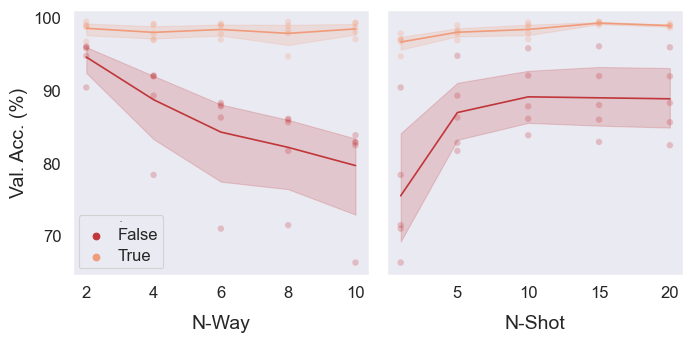

In [14]:
# Set context to paper
sns.set_context("paper")
sns.set_style("dark")

# Plot test/acc vs. n_shot for SOT and non-SOT methods
fig, axs = plt.subplots(ncols=2, figsize=(7, 3.5), sharey=True)

# test/acc ~ n_shot
sns.scatterplot(
    data=df_best_runs,
    x=("config", "n_way"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    alpha=0.25,
    legend=True,
    ax=axs[0],
)
sns.lineplot(
    data=df_best_runs,
    x=("config", "n_way"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    legend=False,
    ax=axs[0],
)

# test/acc ~ n_way
sns.scatterplot(
    data=df_best_runs,
    x=("config", "n_shot"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    alpha=0.25,
    legend=False,
    ax=axs[1],
)
sns.lineplot(
    data=df_best_runs,
    x=("config", "n_shot"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    legend=False,
    ax=axs[1],
)

# Set label size
labsize = 14

# Set title of the legend, adjust font size
axs[0].get_legend().set_title("SOT", prop={"size": 1})
for t in axs[0].get_legend().texts:
    t.set_fontsize(12)

# Set axis labels
axs[0].set_xlabel("N-Way", size=labsize)
axs[1].set_xlabel("N-Shot", size=labsize)

# Add padding between label of x-axis and tick labels
axs[0].xaxis.labelpad = 10
axs[1].xaxis.labelpad = 10

# Set axis labels
axs[0].set_ylabel("Val. Acc. (%)", size=labsize)
axs[1].set_ylabel("")

# Make the ticks descroptors bigger
axs[0].tick_params(labelsize=12)
axs[1].tick_params(labelsize=12)

# Set the tight layout
fig.tight_layout(pad=1.0)

# Save figure
fig.savefig(os.path.join(FIGURE_DIR, "way-shot.pdf"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

## Experiment 3: SOT Interaction

---

We found that SOT interacts in an interesting manner with the re-embedding
modules in distance-based few-shot learners like `ProtoNet` and `MatchingNet`.
In this experiment, we investigate this interaction in more detail. To do this,
we trained `MatchingNet` by enabling the SOT and LSTM embedding for support and
query samples and observe the performance on the test set.


In [15]:
# Experiments
GROUP = "sot-interaction"

# Filter runs by group
group_runs = {
    run.id: run for run in runs if run.group == GROUP and run.state == "finished"
}
print(f"✅ Loaded {len(group_runs)} runs")

✅ Loaded 8 runs


In [16]:
# Load runs into dataframe
df_runs = utils.load_to_df(group_runs.values())

# Load additional information
embed_support = [run.config["method"]["embed_support"] for run in group_runs.values()]
embed_query = [run.config["method"]["embed_query"] for run in group_runs.values()]
df_runs[("config", "embed_support")] = embed_support
df_runs[("config", "embed_query")] = embed_query
print(f"✅ Added meta-information.")

✅ Added meta-information.


✅ Saved figure to /Users/ludekcizinsky/Dev/personal/few-shot-benchmark/figures.


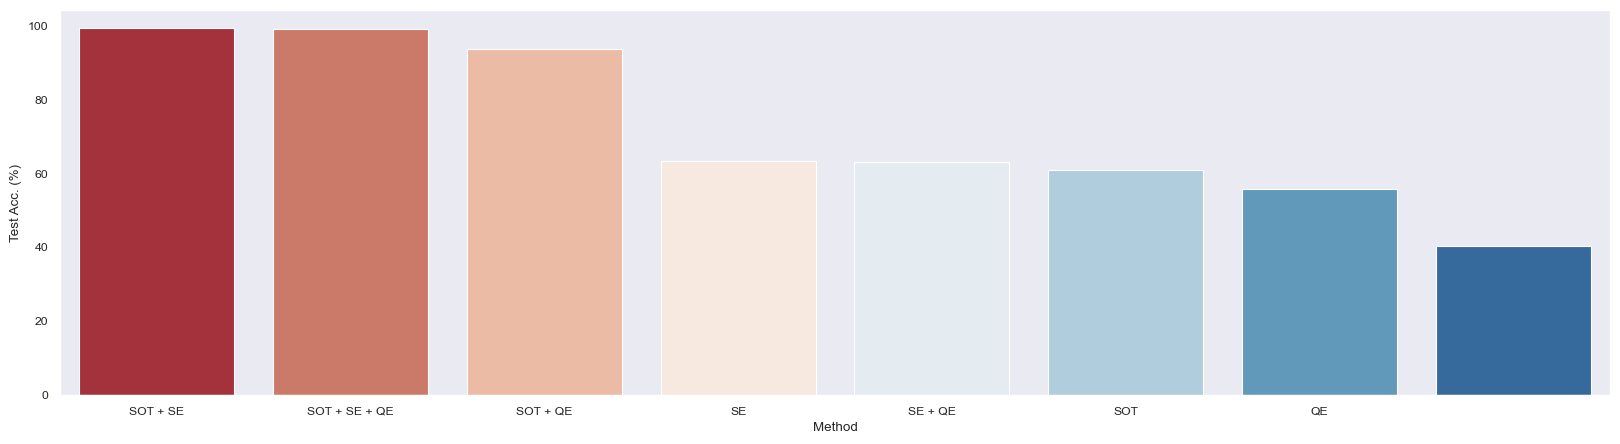

In [17]:
# Plot test/acc vs. name
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(
    data=df_runs.sort_values(by=("eval", "test/acc"), ascending=False),
    x=("info", "name"),
    y=("eval", "test/acc"),
    palette="RdBu",
)
ax.set_xlabel("Method")
ax.set_ylabel("Test Acc. (%)")

# Set axis labels
labels = []
for exp in [l.get_text().split("-")[1::2] for l in ax.get_xticklabels()]:
    name = []
    if exp[0] == "true":
        name.append("SOT")
    if exp[1] == "true":
        name.append("SE")
    if exp[2] == "true":
        name.append("QE")

    labels.append(" + ".join(name))
ax.set_xticklabels(labels)

# Save figure
fig.savefig(os.path.join(FIGURE_DIR, "sot-interaction.pdf"),
            bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

✅ Saved figure to /Users/ludekcizinsky/Dev/personal/few-shot-benchmark/figures.


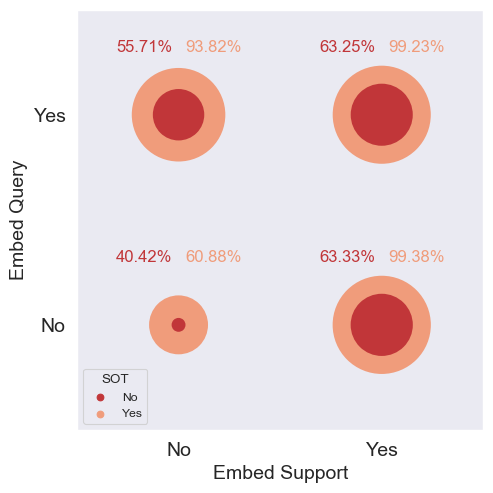

In [36]:
# Scatterplot of interaction between support, query and SOT embeddings
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    df_runs,
    x=("config", "embed_support"),
    y=("config", "embed_query"),
    hue=("config", "use_sot"),
    size=("eval", "test/acc"),
    sizes=(100, 5000),
    linewidth=0,
)

# Set label size
labsize = 14

# Set the labels and ticks of the axes
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["No", "Yes"])
ax.set_yticklabels(["No", "Yes"])
ax.set(
    xlabel="Embed Support",
    ylabel="Embed Query",
)

# Set x and y axis labels size
ax.xaxis.label.set_size(labsize)
ax.yaxis.label.set_size(labsize)


# Add the accuarcy as text to the scatterplot
for i, row in df_runs.iterrows():

    # Get sot flag
    is_sot = row[("config", "use_sot")]

    # Decide on the color of the text based on the SOT flag, use 
    color = sns.color_palette()[1] if is_sot else sns.color_palette()[0] 

    # Define the offset of the text
    y_offset = 0.3 
    x_offset = 0.17 if is_sot else -0.17

    # Add accuracies horizontally centered above the scatterplot
    ax.text(
        x=row[("config", "embed_support")] + x_offset,
        y=row[("config", "embed_query")] + y_offset,
        s=f"{row[('eval', 'test/acc')]:.2f}%",
        color=color,
        horizontalalignment="center",
        size=12,
    )

# Make the ticks descroptors bigger
ax.tick_params(labelsize=labsize)

# Tight layout
fig.tight_layout(pad=1.0)

# Remove the legend
ax.get_legend().remove()

# Add a new custom legend
handles, labels = ax.get_legend_handles_labels()
labels = ["No", "Yes"]
handles = [handles[1], handles[2]]
ax.legend(handles, labels, title="SOT", loc="lower left");

# Save figure
fig.savefig(os.path.join(FIGURE_DIR, "sot-interaction-scatter.pdf"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

✅ Saved figure to /Users/ludekcizinsky/Dev/personal/few-shot-benchmark/figures.


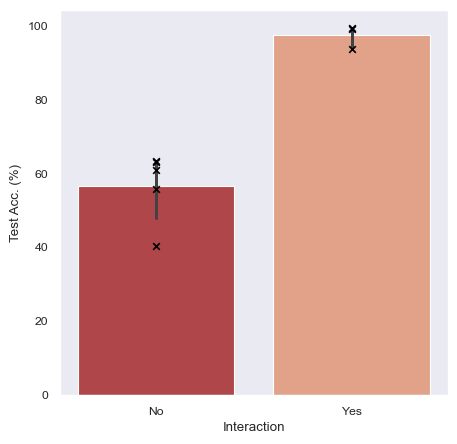

In [19]:
def is_interaction(row):
    support, query, sot = (
        row[("config", "embed_support")],
        row[("config", "embed_query")],
        row[("config", "use_sot")],
    )
    if (support | query) & sot:
        return True
    else:
        return False


df_runs[("config", "interaction")] = df_runs.apply(is_interaction, axis=1)

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    df_runs,
    x=("config", "interaction"),
    y=("eval", "test/acc"),
    ax=ax,
)
ax.scatter(
    x=df_runs[("config", "interaction")],
    y=df_runs[("eval", "test/acc")],
    c="black",
    alpha=1,
    marker="x",
    zorder=100,
)

ax.set_xticklabels(["No", "Yes"])
ax.set_xlabel("Interaction")
ax.set_ylabel("Test Acc. (%)")

# Save figure
fig.savefig(os.path.join(FIGURE_DIR, "sot-interaction-2.pdf"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

## Experiment 4: Understanding model performance

---

The goal of this section will be to compare the improvements of the SOT feature
transform. We will try to understand the improvements by looking at:

- **Embeddings during forward-pass**. Visualise the embeddings of support and
  query samples during episodes with and without SOT enabled.
- **Visualise the self-optimal transport plan.** Visualise the self-optimal
  transport plan for a few episodes via a heat map.
- **Understand model prediction patterns and errors.** Visualise the model
  predictions and errors for a few episodes with and without SOT enabled.

To get started, we will load two pre-trained models from the benchmarking
experiment. We will use two instances of `protonet` that were both trained on
the `tabula_muris` dataset. The first model was trained with the default
configuration, while the second model was trained with the same configuration
but with the `use_sot` flag set to `True`.


In [ ]:
# Experiments
GROUP = "model-behaviour"

# Filter runs by group
runs = [run for run in runs if run.group == GROUP and run.state == "finished"]
print(f"✅ Loaded {len(runs)} runs")

# Load runs into dataframe
df_runs = utils.load_to_df(runs)

df_runs.head()

In [ ]:
# Initialise data loaders and model
models = []
for run in runs:
    # Load data loaders and model
    train_loader, val_loader, test_loader, model = utils.init_all(run)
    models.append(model)

print(f"✅ Initialised data loader and model.")

In [ ]:
# Download artifact (model weights)
for run in runs:
    utils.download_artifact(
        api,
        wandb_entity=WANDB_ENTITY,
        wandb_project=WANDB_PROJECT,
        artifact_dir=ARTIFACT_DIR,
        run_id=run.id,
    )

In [ ]:
# Load model weights
weight_path = os.path.join(ARTIFACT_DIR, runs[0].id, "best_model.pt")
models[0].load_state_dict(torch.load(weight_path))

weight_path = os.path.join(ARTIFACT_DIR, runs[1].id, "best_model.pt")
models[1].load_state_dict(torch.load(weight_path))

print(f"✅ Loaded both model weights.")

In [ ]:
# Evaluate performance
print("Evaluating model with SOT...")
models[0].test_loop(train_loader)
models[0].test_loop(val_loader)
models[0].test_loop(test_loader)

print("\nEvaluating model without SOT...")
models[1].test_loop(train_loader)
models[1].test_loop(val_loader)
models[1].test_loop(test_loader)

print(f"✅ Evaluated both models.")

We have correctly loaded the model weights by confirming the performance on the
`train`, `val` and `test` split for ProtoNet on SwissProt with and without SOT.


### Visualise Embeddings


In [ ]:
# Visualise episode for Protnet w/ SOT
for loader in [train_loader, val_loader, test_loader]:
    utils.visualise_episode(train_loader, models[0])

In [ ]:
# Visualise episode for Protnet w/ SOT
for loader in [train_loader, val_loader, test_loader]:
    utils.visualise_episode(train_loader, models[1])

### Visualise SOT transport plan

Here we visualise the self-optimal transport plan for a few episodes.


In [ ]:
# Visualise transport plan for Protonet w/ SOT on train
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, loader in zip(axs, [train_loader, val_loader, test_loader]):
    utils.visualise_transport_plan(train_loader, models[0], ax=ax)

### Visualise confusion patterns


In [ ]:
# Confusion matrix for Protonet w/ SOT on all splits
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, loader in zip(axs, [train_loader, val_loader, test_loader]):
    utils.visualise_confusion_matrix(loader, models[0], ax=ax)

In [ ]:
# Confusion matrix for Protonet w/o SOT on all splits
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, loader in zip(axs, [train_loader, val_loader, test_loader]):
    utils.visualise_confusion_matrix(loader, models[1], ax=ax)